# 2. Do PNA blockers affect diversity? 

note. the pos ctrl did not have any chloroplast / mitochondria contamination so I excluded these samples here

## Setup

In [1]:
#!mkdir /home/lfloerl/cloud/lfloerl/RxCS_FGCZ/artifacts/16S/PNA-test

In [2]:
wd = '/home/lfloerl/cloud/lfloerl/RxCS_FGCZ/artifacts/16S/PNA-test'
%cd $wd 

/home/lfloerl/cloud/lfloerl/RxCS_FGCZ/artifacts/16S/PNA-test


In [3]:
import os
import json
import pandas as pd
from bs4 import BeautifulSoup
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.lines as mlines

# statistics 
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import permanova
from skbio.stats.distance import DistanceMatrix
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# QIIME 2
import qiime2 as q2
from qiime2 import (Artifact, Metadata)
from qiime2.plugins.feature_table.methods import filter_samples, group
import qiime2.plugins.taxa.actions as taxa_actions
from qiime2.plugins import (feature_table as qft,
                            diversity as q2d,
                            taxa as q2t,
                            composition as comp)
from qiime2.plugins.diversity.visualizers import alpha_group_significance
from qiime2.plugins.diversity.methods import procrustes_analysis
from qiime2.plugins.emperor.visualizers import procrustes_plot
from qiime2.plugins.composition.methods import add_pseudocount


from qiime2 import Visualization
%matplotlib inline

In [4]:
# Load artifacts
# `FeatureTable[Frequency]` filtered 
table_bac = q2.Artifact.load('/home/lfloerl/cloud/lfloerl/RxCS_FGCZ/artifacts/16S/decontam-table.qza')

# load metadata 
metadata = '/home/lfloerl/RxCS/Metadata/16S_PNA-test.csv'
md = Metadata.load(metadata)

# our own fragment insertion tree 
mafft_tree = '/home/lfloerl/cloud/lfloerl/RxCS_FGCZ/artifacts/16S/rooted-tree.qza'
tree = q2.Artifact.load(mafft_tree)

# taxonomy
taxonomy = q2.Artifact.load('/home/lfloerl/cloud/lfloerl/RxCS_FGCZ/artifacts/16S/taxonomy.qza')


## Filter 
first remove chloroplasts & mitochondria, because that's what we'd also do in a regular diversity analysis and would just skew the analysis

In [5]:
table_PNAs = q2.Artifact.load('PNA-table.qza')

# load metadata with reads lost to contamination 
md = Metadata.load('/home/lfloerl/RxCS/Metadata/16S_PNA-test-withLoss.tsv')
md_all = Metadata.load('/home/lfloerl/RxCS/Metadata/16S_metadata.tsv')

In [6]:
exclude_terms = 'mitochondria,chloroplast'

md_filtered_table, = filter_samples(table=table_PNAs,
                                metadata=md,
                                where="[Sample]!='DNA18-pos-1'")

taxa_filtered_table, = q2t.actions.filter_table(
                                table=md_filtered_table, 
                                taxonomy=taxonomy,
                                exclude=exclude_terms)
taxa_filtered_table.save('taxa_filtered_table.qza')

'taxa_filtered_table.qza'

In [67]:
!qiime feature-table summarize --i-table taxa_filtered_table.qza --m-sample-metadata-file /home/lfloerl/RxCS/Metadata/16S_PNA-test-withLoss.tsv --o-visualization taxa_filtered_table.qzv

Saved Visualization to: taxa_filtered_table.qzv


In [68]:
Visualization.load('taxa_filtered_table.qzv')

<visualization: Visualization uuid: 184903a5-3d1e-4233-840a-50196f185e4a>

## Rarefaction 

In [96]:
alpha_rarefaction, = q2d.visualizers.alpha_rarefaction(table=taxa_filtered_table, 
                                                       max_depth=1000,
                                                       metadata=md)
alpha_rarefaction.save('alpha_rarefaction_curves.qzv')

/scratch/lfloerl/.condaenvs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/q2_diversity/_alpha/_visualizer.py:245: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_ = grouped.median()
/scratch/lfloerl/.condaenvs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/q2_diversity/_alpha/_visualizer.py:245: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_ = grouped.median()
/scratch/lfloerl/.condaenvs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/q2_diversity/_alpha/_visualizer.py:245: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future vers

'alpha_rarefaction_curves.qzv'

In [38]:
Visualization.load('alpha_rarefaction_curves.qzv')

<visualization: Visualization uuid: 1e6826c4-b23c-4821-b6bc-b8d080a1dc7f>

## Calculate Diversity Metrics

In [7]:
# let's try to use more metadata, before merging however we have to rename one
md_all_df = md_all.to_dataframe()
md_all_df.rename(columns=lambda x: f'{x}_all', inplace=True)
md_all_renamed = Metadata(md_all_df)

merged_metadata = md.merge(md_all_renamed)

In [8]:
merged_metadata.to_dataframe()

,phylum_filtered_table,contaminants_filtered_table,ChloroMito_filtered_table,contaminants_filtered_table_percentage,ChloroMito_filtered_table_percentage,PNAs,mPNA,pPNA,PNA_mix,PNA_composition,...,GT_all,Block_all,Block_no_all,Year_Cat_all,GT_numb_all,Average_Brix_all,Average_Cluster_Weight_all,Genotype_all,Berry_Color_all,control_all
id,,,,,,,,,,,,,,,,,,,,,
346832_001-LP1-16S-0097,668672.0,563316.0,563128.0,84.243994,84.215879,no,0.00,0.00,None,None0.00.0,...,NaN,NaN,NaN,Yearnan,NaN,NaN,NaN,NaN,NaN,pos_ctrl
346832_002-LP1-16S-0098,764294.0,688882.0,2851.0,90.133116,0.373024,no,0.00,0.00,None,None0.00.0,...,gt48,Block2_noPNAs_0,2_noPNAs_0,Year2022,48,23.0,85.666667,48,Red,sample
346832_003-LP1-16S-0099,878608.0,835291.0,595.0,95.069815,0.067721,no,0.00,0.00,None,None0.00.0,...,gt48,Block1_noPNAs_0,1_noPNAs_0,Year2022,48,NaN,NaN,48,Red,sample
346832_004-LP1-16S-0100,378428.0,25262.0,625.0,6.675510,0.165157,no,0.00,0.00,None,None0.00.0,...,gt110,Block1_noPNAs_0,1_noPNAs_0,Year2022,110,20.8,36.666667,110,Red,sample
346832_005-LP1-16S-0101,719925.0,590457.0,1189.0,82.016460,0.165156,no,0.00,0.00,None,None0.00.0,...,gt147,Block2_noPNAs_0,2_noPNAs_0,Year2022,147,NaN,NaN,147,Red,sample
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346832_939-LP1-16S-1148,535981.0,930.0,733.0,0.173514,0.136759,yes,1.25,1.25,mPNA+pPNA,mPNA+pPNA1.251.25,...,gt110,Block1_m+pPNA_1.25,1_m+pPNA_1.25,Year2022,110,NaN,NaN,110,Red,sample
346832_940-LP1-16S-1149,205112.0,13339.0,1326.0,6.503276,0.646476,yes,1.25,1.25,mPNA+pPNA,mPNA+pPNA1.251.25,...,gt147,Block2_m+pPNA_1.25,2_m+pPNA_1.25,Year2022,147,NaN,NaN,147,Red,sample
346832_941-LP1-16S-1150,592.0,374.0,180.0,63.175676,30.405405,yes,1.25,1.25,mPNA+pPNA,mPNA+pPNA1.251.25,...,gt64,Block2_m+pPNA_1.25,2_m+pPNA_1.25,Year2022,64,NaN,NaN,64,White,sample


In [8]:
depth = 100

threads = 5

In [84]:
core_div_dict = {}

core_div = q2d.actions.core_metrics(table=taxa_filtered_table,
                                                 sampling_depth=depth,
                                                 metadata=merged_metadata,
                                                 n_jobs=threads)
# save outputs
output_dir='cm{0}/'.format(depth)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for k, v in core_div.__dict__.items():
    if k != '_fields':
        v.save(output_dir + k)
        core_div_dict[k] = v

/scratch/lfloerl/.condaenvs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.08031969839102272 and the largest is 6.929744801417249.
  warn(
/scratch/lfloerl/.condaenvs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the No

In [85]:
#output_dir = 'cm100'

In [86]:
Visualization.load(f'{wd}/{output_dir}/bray_curtis_emperor.qzv')

<visualization: Visualization uuid: ada27970-9121-4abb-9f8a-2573936d1e22>

In [87]:
Visualization.load(f'{wd}/{output_dir}/jaccard_emperor.qzv')

<visualization: Visualization uuid: c7f86ee0-aa0a-41d6-bbb0-217be153970e>

## Differential Abundance with ANCOM

In [10]:
merged_metadata.to_dataframe()

,phylum_filtered_table,contaminants_filtered_table,ChloroMito_filtered_table,contaminants_filtered_table_percentage,ChloroMito_filtered_table_percentage,PNAs,mPNA,pPNA,PNA_mix,PNA_composition,...,GT_all,Block_all,Block_no_all,Year_Cat_all,GT_numb_all,Average_Brix_all,Average_Cluster_Weight_all,Genotype_all,Berry_Color_all,control_all
id,,,,,,,,,,,,,,,,,,,,,
346832_001-LP1-16S-0097,668672.0,563316.0,563128.0,84.243994,84.215879,no,0.00,0.00,None,None0.00.0,...,NaN,NaN,NaN,Yearnan,NaN,NaN,NaN,NaN,NaN,pos_ctrl
346832_002-LP1-16S-0098,764294.0,688882.0,2851.0,90.133116,0.373024,no,0.00,0.00,None,None0.00.0,...,gt48,Block2_noPNAs_0,2_noPNAs_0,Year2022,48,23.0,85.666667,48,Red,sample
346832_003-LP1-16S-0099,878608.0,835291.0,595.0,95.069815,0.067721,no,0.00,0.00,None,None0.00.0,...,gt48,Block1_noPNAs_0,1_noPNAs_0,Year2022,48,NaN,NaN,48,Red,sample
346832_004-LP1-16S-0100,378428.0,25262.0,625.0,6.675510,0.165157,no,0.00,0.00,None,None0.00.0,...,gt110,Block1_noPNAs_0,1_noPNAs_0,Year2022,110,20.8,36.666667,110,Red,sample
346832_005-LP1-16S-0101,719925.0,590457.0,1189.0,82.016460,0.165156,no,0.00,0.00,None,None0.00.0,...,gt147,Block2_noPNAs_0,2_noPNAs_0,Year2022,147,NaN,NaN,147,Red,sample
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346832_939-LP1-16S-1148,535981.0,930.0,733.0,0.173514,0.136759,yes,1.25,1.25,mPNA+pPNA,mPNA+pPNA1.251.25,...,gt110,Block1_m+pPNA_1.25,1_m+pPNA_1.25,Year2022,110,NaN,NaN,110,Red,sample
346832_940-LP1-16S-1149,205112.0,13339.0,1326.0,6.503276,0.646476,yes,1.25,1.25,mPNA+pPNA,mPNA+pPNA1.251.25,...,gt147,Block2_m+pPNA_1.25,2_m+pPNA_1.25,Year2022,147,NaN,NaN,147,Red,sample
346832_941-LP1-16S-1150,592.0,374.0,180.0,63.175676,30.405405,yes,1.25,1.25,mPNA+pPNA,mPNA+pPNA1.251.25,...,gt64,Block2_m+pPNA_1.25,2_m+pPNA_1.25,Year2022,64,NaN,NaN,64,White,sample


In [ ]:
filtered_table, = qft.actions.filter_features(taxa_filtered_table, min_frequency = 5, min_samples = 1)
ancom_table, = comp.methods.add_pseudocount(filtered_table)
ancom_table.save('ancom_table.qza')

In [11]:
ancom = comp.actions.ancom(table=ancom_table, metadata=merged_metadata.get_column('PNAs'))
ancom.visualization
# PNAs.tsv

/scratch/lfloerl/.condaenvs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


<visualization: Visualization uuid: 027b8ee7-6985-4811-a5e9-bba051fbc448>

In [12]:
ancom = comp.actions.ancom(table=ancom_table, metadata=merged_metadata.get_column('PNA_composition'))
ancom.visualization
# PNA_composition.tsv

/scratch/lfloerl/.condaenvs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


<visualization: Visualization uuid: 1b80e4c8-d408-4b19-8f9d-9715ebb79ee3>

In [13]:
ancom = comp.actions.ancom(table=ancom_table, metadata=merged_metadata.get_column('PNA_mix'))
ancom.visualization
# PNA_mix.tsv

/scratch/lfloerl/.condaenvs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


<visualization: Visualization uuid: bdb1afe3-c20d-49db-a979-3919583aee05>

save as tsv and merge with taxonomy:

In [14]:
%%bash

 # combine the taxa table with the abundant features 
qiime metadata tabulate \
  --m-input-file /home/lfloerl/cloud/lfloerl/RxCS_FGCZ/artifacts/16S/taxonomy.qza  \
  --m-input-file ANCOM/PNAs.tsv \
  --o-visualization ANCOM/ANCOM_PNAs.qzv

qiime metadata tabulate \
  --m-input-file /home/lfloerl/cloud/lfloerl/RxCS_FGCZ/artifacts/16S/taxonomy.qza  \
  --m-input-file ANCOM/PNA_mix.tsv \
  --o-visualization ANCOM/ANCOM_PNAmix.qzv
  
qiime metadata tabulate \
  --m-input-file /home/lfloerl/cloud/lfloerl/RxCS_FGCZ/artifacts/16S/taxonomy.qza  \
  --m-input-file ANCOM/PNA_composition.tsv \
  --o-visualization ANCOM/ANCOM_PNAcomposition.qzv

Saved Visualization to: ANCOM/ANCOM_PNAs.qzv
Saved Visualization to: ANCOM/ANCOM_PNAmix.qzv
Saved Visualization to: ANCOM/ANCOM_PNAcomposition.qzv


In [1]:
Visualization.load('ANCOM/ANCOM_PNAs.qzv')

NameError: name 'Visualization' is not defined

In [5]:
Visualization.load('ANCOM/ANCOM_PNAmix.qzv')

<visualization: Visualization uuid: 2d423884-5fd2-48e1-8b94-c725f76be6e1>

In [3]:
Visualization.load('ANCOM/ANCOM_PNAcomposition.qzv')

<visualization: Visualization uuid: 3bb86868-23ce-43bd-ac24-093ea13c0c89>

## Nicer visualizations of the PCoA

In [29]:
#!qiime tools export --input-path cm100/jaccard_pcoa_results.qza --output-path cm100/jaccard_pcoa
#!qiime tools export --input-path cm100/bray_curtis_pcoa_results.qza --output-path cm100/bray_curtis_pcoa

Exported cm100/jaccard_pcoa_results.qza as OrdinationDirectoryFormat to directory cm100/jaccard_pcoa
Exported cm100/bray_curtis_pcoa_results.qza as OrdinationDirectoryFormat to directory cm100/bray_curtis_pcoa


In [5]:
# reimport 
bc_pcoa = pd.read_csv('cm100/bray_curtis_pcoa/ordination.txt', sep='\t', skiprows=9, header=None)
jaccard_pcoa = pd.read_csv('cm100/jaccard_pcoa/ordination.txt', sep='\t', skiprows=9, header=None)

# function to get components 
def select_components(df):
    # Drop the last 4 rows
    df = df.iloc[:-4]
    # Select specific columns
    df = df.iloc[:, [0, 1, 3]]
    # Rename columns and set index
    df = df.rename(columns={0: 'ID', 1: 'PC1', 3: 'PC2'}).set_index('ID')
    return df

bc_pcoa_df = select_components(bc_pcoa)
jaccard_pcoa_df = select_components(jaccard_pcoa)

In [6]:
# rename the index by the sample type 
md = pd.read_csv('/home/lfloerl/RxCS/Metadata/16S_PNA-test-withLoss.tsv', sep='\t')

bc_pcoa_df_merged = bc_pcoa_df.merge(md[['sample-id', 'PNAs', 'Sample']], left_on='ID', right_on='sample-id', how='left')
jaccard_pcoa_df_merged = jaccard_pcoa_df.merge(md[['sample-id', 'PNAs', 'Sample']], left_on='ID', right_on='sample-id', how='left')

In [7]:
sample_mapping = {original: f"Sample-{i+1}" for i, original in enumerate(bc_pcoa_df_merged['Sample'].unique())}
bc_pcoa_df_merged['Sample'] = bc_pcoa_df_merged['Sample'].replace(sample_mapping)
jaccard_pcoa_df_merged['Sample'] = jaccard_pcoa_df_merged['Sample'].replace(sample_mapping)


bc_pcoa_df_merged.head()

,PC1,PC2,sample-id,PNAs,Sample
0,0.096979,0.054030,346832_002-LP1-16S-0098,no,Sample-1
1,-0.571601,-0.154587,346832_003-LP1-16S-0099,no,Sample-2
2,0.337597,-0.294252,346832_004-LP1-16S-0100,no,Sample-3
3,0.077345,0.430915,346832_005-LP1-16S-0101,no,Sample-4
4,0.005389,-0.007532,346832_006-LP1-16S-0102,no,Sample-5


In [8]:
manual_colors = {
    "Sample-1": "#440154FF",
    "Sample-2": "#443A83FF",
    "Sample-3": "#31688EFF",
    "Sample-4": "#21908CFF",
    "Sample-5": "#35B779FF",
    "Sample-6": "#8FD744FF",
    "Sample-7": "#FDE725FF"
}

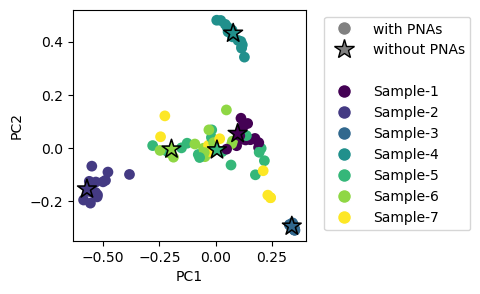

In [9]:
# Map the colors to the DataFrame
bc_pcoa_df_merged['color'] = bc_pcoa_df_merged['Sample'].map(manual_colors)

# Define marker styles based on PNAs
marker_styles = {'yes': 'o', 'no': '*'}

# Create figure
plt.figure(figsize=(3, 3))
plt.tight_layout()

# Plot the remaining markers
other_data = bc_pcoa_df_merged[bc_pcoa_df_merged['PNAs'] != 'no']
sns.scatterplot(
    x='PC1', y='PC2',
    data=other_data,
    hue='Sample',
    palette=manual_colors,
    style='PNAs',
    markers=marker_styles['yes'],
    s=60,
    edgecolor='none',
    legend=None
)

# Plot markers with star style separately
star_data = bc_pcoa_df_merged[bc_pcoa_df_merged['PNAs'] == 'no']
sns.scatterplot(
    x='PC1', y='PC2',
    data=star_data,
    hue='Sample',
    palette=manual_colors,
    style='PNAs',
    markers=marker_styles['no'],
    s=200,  # Larger size for star markers
    edgecolor='black',  # Edge color for star markers
    legend=None
)


# Create custom legend
handles = [
    plt.Line2D([], [], marker=marker_styles['yes'], color='w', markerfacecolor='grey', markersize=10, label='with PNAs'),
    plt.Line2D([], [], marker=marker_styles['no'], color='w', markerfacecolor='grey', markersize=15, markeredgecolor='black', label='without PNAs'),
    plt.Line2D([], [], color='none', label='   '),  # Spacer
]
handles += [plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, markersize=10, label=index)
            for index, color in manual_colors.items()]

plt.legend(
    handles=handles,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handlelength=2,  # Length of the legend handle
    handletextpad=1.1,  # Space between the handle and the label
    columnspacing=2  # Space between columns (if multiple columns are used)
)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.savefig('BC_PCoA.png', dpi=300, bbox_inches='tight')
plt.show()

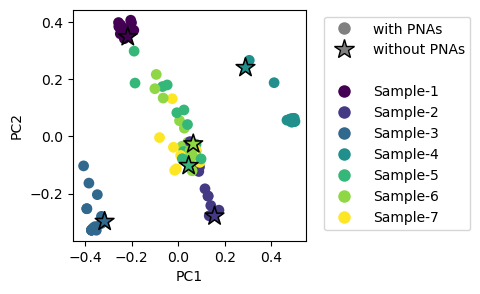

In [10]:
# Map the colors to the DataFrame
jaccard_pcoa_df_merged['color'] = jaccard_pcoa_df_merged['Sample'].map(manual_colors)

# Define marker styles based on PNAs
marker_styles = {'yes': 'o', 'no': '*'}

# Create figure
plt.figure(figsize=(3, 3))
plt.tight_layout()

# Plot the remaining markers
other_data = jaccard_pcoa_df_merged[jaccard_pcoa_df_merged['PNAs'] != 'no']
sns.scatterplot(
    x='PC1', y='PC2',
    data=other_data,
    hue='Sample',
    palette=manual_colors,
    style='PNAs',
    markers=marker_styles['yes'],
    s=60,
    edgecolor='none',
    legend=None
)

# Plot markers with star style separately

star_data = jaccard_pcoa_df_merged[jaccard_pcoa_df_merged['PNAs'] == 'no']
sns.scatterplot(
    x='PC1', y='PC2',
    data=star_data,
    hue='Sample',
    palette=manual_colors,
    style='PNAs',
    markers=marker_styles['no'],
    s=200,  # Larger size for star markers
    edgecolor='black',  # Edge color for star markers
    legend=None
)

# Create custom legend
handles = [
    plt.Line2D([], [], marker=marker_styles['yes'], color='w', markerfacecolor='grey', markersize=10, label='with PNAs'),
    plt.Line2D([], [], marker=marker_styles['no'], color='w', markerfacecolor='grey', markersize=15, markeredgecolor='black', label='without PNAs'),
    plt.Line2D([], [], color='none', label='   '),  # Spacer
]
handles += [plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, markersize=10, label=index)
            for index, color in manual_colors.items()]

plt.legend(
    handles=handles,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handlelength=2,  # Length of the legend handle
    handletextpad=1.1,  # Space between the handle and the label
    columnspacing=2  # Space between columns (if multiple columns are used)
)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.savefig('Jaccard_PCoA.png', dpi=300, bbox_inches='tight')
plt.show()

## Alpha Group Significance  

In [34]:
# metrics: 
alpha_metrics = ['shannon_vector', 'observed_features_vector', 'evenness_vector']

for m in alpha_metrics:
    ags, = alpha_group_significance(alpha_diversity = core_div_dict[m],
                               metadata = md)
    ags.save(output_dir + 'alpha_groupSig_{0}.qzv'.format(m))

In [5]:
output_dir = 'cm100'

In [6]:
Visualization.load(f'{wd}/{output_dir}/alpha_groupSig_evenness_vector.qzv')

<visualization: Visualization uuid: 2287364c-db46-4a1f-9541-48581176b7a4>

In [7]:
Visualization.load(f'{wd}/{output_dir}/alpha_groupSig_shannon_vector.qzv')

<visualization: Visualization uuid: a2e1c17a-97c9-4a3f-8c3f-ce65302e878c>

In [8]:
Visualization.load(f'{wd}/{output_dir}/alpha_groupSig_observed_features_vector.qzv')

<visualization: Visualization uuid: 49c099f9-847b-425a-9367-d8af7c37d0b7>

## PERMANOVA with ADONIS 

In [38]:
md.to_dataframe()

,phylum_filtered_table,contaminants_filtered_table,ChloroMito_filtered_table,contaminants_filtered_table_percentage,ChloroMito_filtered_table_percentage,PNAs,mPNA,pPNA,PNA_mix,PNA_composition,Sample
sample-id,,,,,,,,,,,
346832_001-LP1-16S-0097,668672.0,563316.0,563128.0,84.243994,84.215879,no,0.00,0.00,None,None0.00.0,DNA18-pos-1
346832_002-LP1-16S-0098,764294.0,688882.0,2851.0,90.133116,0.373024,no,0.00,0.00,None,None0.00.0,Must-20-AUG-2022-gt48-Block2
346832_003-LP1-16S-0099,878608.0,835291.0,595.0,95.069815,0.067721,no,0.00,0.00,None,None0.00.0,Must-20-AUG-2022-gt48-Block1
346832_004-LP1-16S-0100,378428.0,25262.0,625.0,6.675510,0.165157,no,0.00,0.00,None,None0.00.0,Must-27-AUG-2022-gt110-Block1
346832_005-LP1-16S-0101,719925.0,590457.0,1189.0,82.016460,0.165156,no,0.00,0.00,None,None0.00.0,Must-27-AUG-2022-gt147-Block2
...,...,...,...,...,...,...,...,...,...,...,...
346832_939-LP1-16S-1148,535981.0,930.0,733.0,0.173514,0.136759,yes,1.25,1.25,mPNA+pPNA,mPNA+pPNA1.251.25,Must-27-AUG-2022-gt110-Block1
346832_940-LP1-16S-1149,205112.0,13339.0,1326.0,6.503276,0.646476,yes,1.25,1.25,mPNA+pPNA,mPNA+pPNA1.251.25,Must-27-AUG-2022-gt147-Block2
346832_941-LP1-16S-1150,592.0,374.0,180.0,63.175676,30.405405,yes,1.25,1.25,mPNA+pPNA,mPNA+pPNA1.251.25,Must-20-AUG-2022-gt64-Block2


In [42]:
formula = 'Sample * PNAs' 

beta_metrics = ['bray_curtis', 'jaccard']


for m in beta_metrics:
    adonis_res, = q2d.actions.adonis(
        distance_matrix=core_div_dict[m + '_distance_matrix'],
        metadata=md,
        formula=formula,
        n_jobs=threads)
    adonis_res.save(output_dir + 'adonis_{0}.qzv'.format(m))

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: run_adonis.R /scratch/lfloerl/tmpdata/tmp5xnno9_a/dm.tsv /scratch/lfloerl/tmpdata/tmp5xnno9_a/md.tsv Sample + pPNA + mPNA 999 5 /scratch/lfloerl/tmpdata/qiime2-temp-7bxo5q18/adonis.tsv

R version 4.2.2 (2022-10-31) 


Lade nötiges Paket: permute
Lade nötiges Paket: lattice
This is vegan 2.6-4
'adonis' will be deprecated: use 'adonis2' instead


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: run_adonis.R /scratch/lfloerl/tmpdata/tmp6rwmg1xl/dm.tsv /scratch/lfloerl/tmpdata/tmp6rwmg1xl/md.tsv Sample + pPNA + mPNA 999 5 /scratch/lfloerl/tmpdata/qiime2-temp-090oz6yr/adonis.tsv

R version 4.2.2 (2022-10-31) 


Lade nötiges Paket: permute
Lade nötiges Paket: lattice
This is vegan 2.6-4
'adonis' will be deprecated: use 'adonis2' instead


In [43]:
Visualization.load(f'{wd}/{output_dir}/adonis_jaccard.qzv')

<visualization: Visualization uuid: eb29eb12-4db5-4b53-8802-806549af43d5>

In [44]:
Visualization.load(f'{wd}/{output_dir}/adonis_bray_curtis.qzv')

<visualization: Visualization uuid: 24d7f247-585d-43e9-bd73-c1383708b64d>

<hr>


# Appendix: Let's check if PNAs contributed to the reagent contamination 

In [12]:
%%bash 

# classified to feature level
qiime taxa filter-table \
  --i-table /home/lfloerl/cloud/lfloerl/RxCS_FGCZ/artifacts/16S/decontam-table.qza \
  --i-taxonomy /home/lfloerl/cloud/lfloerl/RxCS_FGCZ/artifacts/16S/taxonomy.qza \
  --p-include p__ \
  --p-exclude Eukaryota,Archaea \
  --o-filtered-table phylum_filtered_table.qza
  
qiime feature-table summarize --i-table phylum_filtered_table.qza --o-visualization phylum_filtered_table.qzv

# remove contaminants 
qiime taxa filter-table \
  --i-table phylum_filtered_table.qza \
  --i-taxonomy /home/lfloerl/cloud/lfloerl/RxCS_FGCZ/artifacts/16S/taxonomy.qza \
  --p-exclude Alcaligenaceae,Caulobacteraceae,Comamonadaceae,Pedobacter,Escherichia-Shigella \
  --o-filtered-table contaminants_filtered_table.qza
  
qiime feature-table summarize --i-table contaminants_filtered_table.qza --o-visualization contaminants_filtered_table.qzv

# remove chloroplasts, mitochondria  
qiime taxa filter-table \
  --i-table contaminants_filtered_table.qza \
  --i-taxonomy /home/lfloerl/cloud/lfloerl/RxCS_FGCZ/artifacts/16S/taxonomy.qza \
  --p-exclude mitochondria,chloroplast \
  --o-filtered-table ChloroMito_filtered_table.qza
  
qiime feature-table summarize --i-table ChloroMito_filtered_table.qza --o-visualization ChloroMito_filtered_table.qzv

Saved FeatureTable[Frequency] to: phylum_filtered_table.qza
Saved Visualization to: phylum_filtered_table.qzv
Saved FeatureTable[Frequency] to: contaminants_filtered_table.qza
Saved Visualization to: contaminants_filtered_table.qzv
Saved FeatureTable[Frequency] to: ChloroMito_filtered_table.qza
Saved Visualization to: ChloroMito_filtered_table.qzv


In [26]:
!qiime tools export --input-path ChloroMito_filtered_table.qzv --output-path ChloroMito_filtered_table
!qiime tools export --input-path contaminants_filtered_table.qzv --output-path contaminants_filtered_table
!qiime tools export --input-path phylum_filtered_table.qzv --output-path phylum_filtered_table

Exported ChloroMito_filtered_table.qzv as Visualization to directory ChloroMito_filtered_table
Exported contaminants_filtered_table.qzv as Visualization to directory contaminants_filtered_table
Exported phylum_filtered_table.qzv as Visualization to directory phylum_filtered_table


In [7]:
def extract_frequency_data(folder_name):
    """
    Extracts sample frequency data from an HTML file in a specified folder.

    Parameters:
    folder_name (str): The name of the folder containing the 'sample-frequency-detail.html' file.

    Returns:
    pd.DataFrame: A DataFrame indexed by Sample_ID with a column for the specified folder's Frequency.
    """
    file_path = os.path.join(folder_name, 'sample-frequency-detail.html')
    
    # Load the HTML file
    with open(file_path, 'r') as file:
        soup = BeautifulSoup(file, 'lxml')

    # Find the <script> tag with type="application/json" and id="table-data"
    script_tag = soup.find('script', type='application/json', id='table-data')

    # Check if the script tag was found
    if script_tag:
        # Extract the JSON content from the <script> tag
        json_data = json.loads(script_tag.string)
        
        # Convert the JSON data to a Pandas DataFrame
        filtered_reads = pd.DataFrame(list(json_data.items()), columns=['Sample_ID', folder_name])
        
        # Convert the folder's frequency column to numeric
        filtered_reads[folder_name] = filtered_reads[folder_name].str.replace(',', '').astype(int)
        
        # Set Sample_ID as the index
        filtered_reads.set_index('Sample_ID', inplace=True)
        
        return filtered_reads
    else:
        print(f"No script tag with type 'application/json' found in {file_path}.")
        return pd.DataFrame()  # Return an empty DataFrame if no data is found

# List of folders to process
folder_names = ['phylum_filtered_table', 'contaminants_filtered_table', 'ChloroMito_filtered_table']

# Initialize an empty DataFrame to store all results
all_data = pd.DataFrame()

# Loop through each folder and merge the results into a single DataFrame
for folder in folder_names:
    df = extract_frequency_data(folder)
    if not df.empty:
        if all_data.empty:
            all_data = df
        else:
            all_data = all_data.join(df, how='outer')

In [8]:
# Calculate percentage of reads lost in contaminants_filtered_table
all_data['contaminants_filtered_table_percentage'] = (
    (all_data['contaminants_filtered_table'] / all_data['phylum_filtered_table']) * 100
)

# Calculate percentage of reads conserved in ChloroMito_filtered_table
all_data['ChloroMito_filtered_table_percentage'] = (
    (all_data['ChloroMito_filtered_table'] / all_data['phylum_filtered_table']) * 100
)

all_data.head()

,phylum_filtered_table,contaminants_filtered_table,ChloroMito_filtered_table,contaminants_filtered_table_percentage,ChloroMito_filtered_table_percentage
Sample_ID,,,,,
346832_001-LP1-16S-0097,668672,563316.0,563128.0,84.243994,84.215879
346832_002-LP1-16S-0098,764294,688882.0,2851.0,90.133116,0.373024
346832_003-LP1-16S-0099,878608,835291.0,595.0,95.069815,0.067721
346832_004-LP1-16S-0100,378428,25262.0,625.0,6.675510,0.165157
346832_005-LP1-16S-0101,719925,590457.0,1189.0,82.016460,0.165156


In [80]:
# this is the metadata we use 
md_bac = pd.read_csv('/home/lfloerl/RxCS/Metadata/16S_PNA-test.csv', sep='\t', index_col=0)
md_bac.head()

,Sample_ID,Plate,Position,DNA_extraction_plate,Conc_Bac_30X,PNA_test,PNAs,mPNA,pPNA,Year,...,Block,Block_no,GT_numb,Average_Brix,Average_Cluster_Weight,Genotype,Berry_Color,PNA_mix,PNA_composition,Sample
ID,,,,,,,,,,,,,,,,,,,,,
346832_018-LP1-16S-0114,Must-20-AUG-2022-gt48-Block2_mPNA_0.5,P2_PNA,B03,NaN,2.103733,yes,yes,0.50,0.00,2022.0,...,Block2_mPNA_0.5,2_mPNA_0.5,48.0,23.933333,43.333333,48.0,Red,mPNA,mPNA0.50.0,Must-20-AUG-2022-gt48-Block2
346832_083-LP1-16S-0179,Must-20-AUG-2022-gt48-Block1_pPNA_1.25,P2_PNA,C11,NaN,7.106294,yes,yes,0.00,1.25,2022.0,...,Block1_pPNA_1.25,1_pPNA_1.25,48.0,24.633333,147.666667,48.0,Red,pPNA,pPNA0.01.25,Must-20-AUG-2022-gt48-Block1
346832_922-LP1-16S-1131,Must-20-AUG-2022-gt48-Block1_m+pPNA_0.75,P12,C10,DNA23,11.792798,yes,yes,0.75,0.75,2022.0,...,Block1_m+pPNA_0.75,1_m+pPNA_0.75,48.0,23.100000,142.333333,48.0,Red,mPNA+pPNA,mPNA+pPNA0.750.75,Must-20-AUG-2022-gt48-Block1
346832_619-LP1-16S-0779,Must-20-AUG-2022-gt48-Block1,P9,C02,DNA18,1.188433,yes,yes,0.50,0.50,2022.0,...,Block1,1,48.0,23.400000,78.000000,48.0,Red,mPNA+pPNA,mPNA+pPNA0.50.5,Must-20-AUG-2022-gt48-Block1
346832_067-LP1-16S-0163,Must-20-AUG-2022-gt48-Block1_pPNA_0.75,P2_PNA,C09,NaN,2.343575,yes,yes,0.00,0.75,2022.0,...,Block1_pPNA_0.75,1_pPNA_0.75,48.0,21.400000,87.000000,48.0,Red,pPNA,pPNA0.00.75,Must-20-AUG-2022-gt48-Block1


In [74]:
merged_df = pd.merge(all_data, md_bac[['PNAs', 'mPNA', 'pPNA', 'PNA_mix','PNA_composition','Sample']], left_index=True, right_index=True, how='inner')
merged_df

,phylum_filtered_table,contaminants_filtered_table,ChloroMito_filtered_table,contaminants_filtered_table_percentage,ChloroMito_filtered_table_percentage,PNAs,mPNA,pPNA,PNA_mix,PNA_composition,Sample
346832_001-LP1-16S-0097,668672,563316.0,563128.0,84.243994,84.215879,no,0.00,0.00,None,None0.00.0,DNA18-pos-1
346832_002-LP1-16S-0098,764294,688882.0,2851.0,90.133116,0.373024,no,0.00,0.00,None,None0.00.0,Must-20-AUG-2022-gt48-Block2
346832_003-LP1-16S-0099,878608,835291.0,595.0,95.069815,0.067721,no,0.00,0.00,None,None0.00.0,Must-20-AUG-2022-gt48-Block1
346832_004-LP1-16S-0100,378428,25262.0,625.0,6.675510,0.165157,no,0.00,0.00,None,None0.00.0,Must-27-AUG-2022-gt110-Block1
346832_005-LP1-16S-0101,719925,590457.0,1189.0,82.016460,0.165156,no,0.00,0.00,None,None0.00.0,Must-27-AUG-2022-gt147-Block2
...,...,...,...,...,...,...,...,...,...,...,...
346832_939-LP1-16S-1148,535981,930.0,733.0,0.173514,0.136759,yes,1.25,1.25,mPNA+pPNA,mPNA+pPNA1.251.25,Must-27-AUG-2022-gt110-Block1
346832_940-LP1-16S-1149,205112,13339.0,1326.0,6.503276,0.646476,yes,1.25,1.25,mPNA+pPNA,mPNA+pPNA1.251.25,Must-27-AUG-2022-gt147-Block2
346832_941-LP1-16S-1150,592,374.0,180.0,63.175676,30.405405,yes,1.25,1.25,mPNA+pPNA,mPNA+pPNA1.251.25,Must-20-AUG-2022-gt64-Block2
346832_942-LP1-16S-1151,4279,393.0,89.0,9.184389,2.079925,yes,1.25,1.25,mPNA+pPNA,mPNA+pPNA1.251.25,Must-20-AUG-2022-gt5-Block2


In [75]:
merged_df.index.name = 'sample-id'
merged_df.to_csv('/home/lfloerl/RxCS/Metadata/16S_PNA-test-withLoss.tsv', sep='\t', index=1)

/scratch/lfloerl/tmpdata/ipykernel_618850/298591712.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_melted, x='Filtering_Step', y='Value', hue='PNA_composition', ci='sd', palette=palette, linewidth=2)


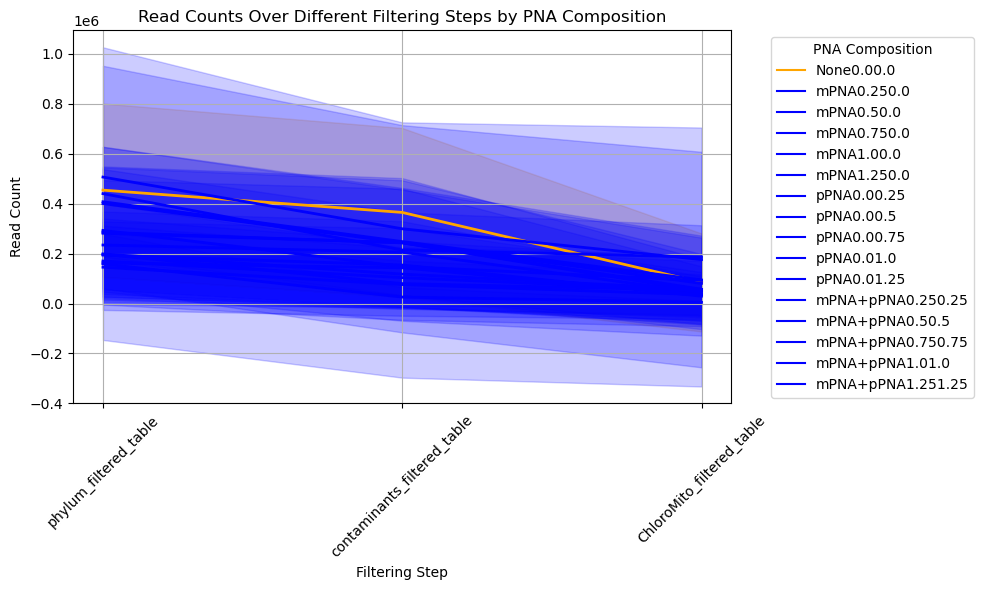

In [84]:
# Melt the DataFrame to long format
df_melted = merged_df.melt(id_vars=['PNA_composition'], 
                           value_vars=['phylum_filtered_table', 'contaminants_filtered_table', 'ChloroMito_filtered_table'],
                           var_name='Filtering_Step', value_name='Value')

# Create a custom color palette
base_color = 'blue'  # Base color for all lines
highlight_color = 'orange'  # Highlight color for 'None0.00.0'

# Get unique PNA_composition values
unique_pna = df_melted['PNA_composition'].unique()

# Generate a palette where all lines except 'None0.00.0' have the same base color with different shadings
palette = {pna: highlight_color if pna == 'None0.00.0' else base_color for pna in unique_pna}

# Plot the data with a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='Filtering_Step', y='Value', hue='PNA_composition', ci='sd', palette=palette, linewidth=2)

# Customize the plot
plt.title('Read Counts Over Different Filtering Steps by PNA Composition')
plt.xlabel('Filtering Step')
plt.ylabel('Read Count')
plt.xticks(rotation=45)

# Move the legend to the right outside the graph
plt.legend(title='PNA Composition', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [17]:
# Categorize PNA_composition into 'None0.00.0' and 'Other', and create a new column
merged_df['PNA_Category'] = merged_df['PNA_composition'].apply(lambda x: 'None0.00.0' if x == 'None0.00.0' else 'Other')

# Separate data based on categories
none_pna = merged_df[merged_df['PNA_Category'] == 'None0.00.0']['contaminants_filtered_table_percentage']
other_pna = merged_df[merged_df['PNA_Category'] == 'Other']['contaminants_filtered_table_percentage']

# Perform t-test
t_stat, p_value = stats.ttest_ind(none_pna, other_pna, nan_policy='omit')

print(f"T-test result: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

T-test result: t-statistic = 2.087, p-value = 0.037


In [19]:
corr_df = merged_df[['contaminants_filtered_table_percentage', 'mPNA', 'pPNA','Sample']]
corr_df.head()

,contaminants_filtered_table_percentage,mPNA,pPNA,Sample
Sample_ID,,,,
346832_001-LP1-16S-0097,84.243994,0.0,0.0,DNA18-pos-1
346832_002-LP1-16S-0098,90.133116,0.0,0.0,Must-20-AUG-2022-gt48-Block2
346832_003-LP1-16S-0099,95.069815,0.0,0.0,Must-20-AUG-2022-gt48-Block1
346832_004-LP1-16S-0100,6.675510,0.0,0.0,Must-27-AUG-2022-gt110-Block1
346832_005-LP1-16S-0101,82.016460,0.0,0.0,Must-27-AUG-2022-gt147-Block2


/scratch/lfloerl/tmpdata/ipykernel_618850/1007663749.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = corr_df.corr(method='spearman')


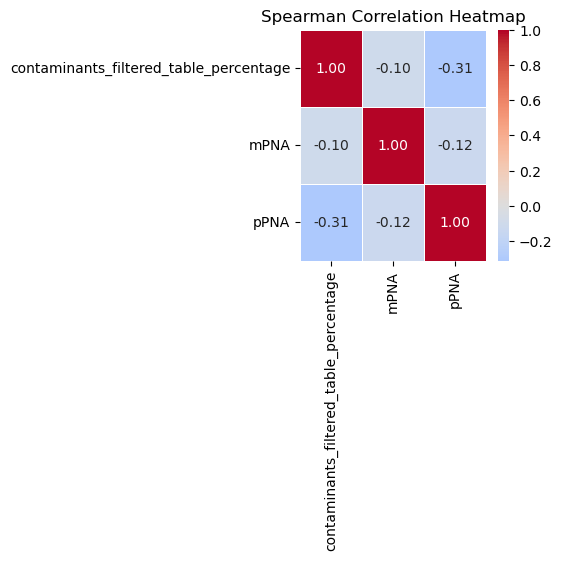

In [87]:
# Calculate Pearson correlation matrix
corr_matrix = corr_df.corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(3,3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Spearman Correlation Heatmap')
plt.show()

/scratch/lfloerl/tmpdata/ipykernel_437768/1101071638.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = corr_df.corr(method='pearson')


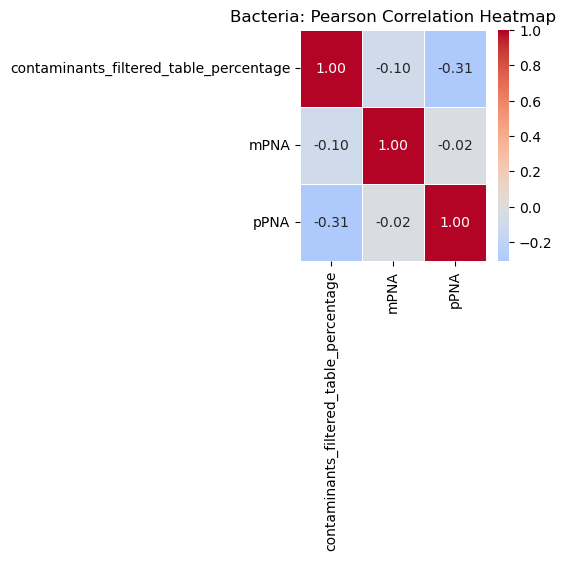

In [90]:
# Calculate Pearson correlation matrix
corr_matrix = corr_df.corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(3,3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Bacteria: Pearson Correlation Heatmap')
plt.show()

In [25]:
permanova_df = merged_df[['contaminants_filtered_table_percentage','Sample','PNA_composition']]
permanova_df.head()

,contaminants_filtered_table_percentage,Sample,PNA_composition
Sample_ID,,,
346832_001-LP1-16S-0097,84.243994,DNA18-pos-1,None0.00.0
346832_002-LP1-16S-0098,90.133116,Must-20-AUG-2022-gt48-Block2,None0.00.0
346832_003-LP1-16S-0099,95.069815,Must-20-AUG-2022-gt48-Block1,None0.00.0
346832_004-LP1-16S-0100,6.675510,Must-27-AUG-2022-gt110-Block1,None0.00.0
346832_005-LP1-16S-0101,82.016460,Must-27-AUG-2022-gt147-Block2,None0.00.0


In [21]:

# Create a distance matrix based on contaminants_filtered_table_percentage
distance_matrix = squareform(pdist(permanova_df[['contaminants_filtered_table_percentage']], metric='euclidean'))

# Perform PERMANOVA using statsmodels for Sample
permanova_df['Sample_encoded'] = permanova_df['Sample'].astype('category').cat.codes
model_sample = ols('contaminants_filtered_table_percentage ~ C(Sample_encoded)', data=permanova_df).fit()
anova_table_sample = anova_lm(model_sample, typ=2)
# Calculate R^2
ss_model = anova_table_sample['sum_sq']['C(Sample_encoded)']
ss_total = ss_model + anova_table_sample['sum_sq']['Residual']
r_squared = ss_model / ss_total

print("PERMANOVA results for Sample:")
print(anova_table_sample)
print(f"R^2: {r_squared:.3f}")


# Perform PERMANOVA using statsmodels for PNA_composition
permanova_df['PNA_composition_encoded'] = permanova_df['PNA_composition'].astype('category').cat.codes
model_pna = ols('contaminants_filtered_table_percentage ~ C(PNA_composition_encoded)', data=permanova_df).fit()
anova_table_pna = anova_lm(model_pna, typ=2)
# Calculate R^2
ss_model_pna = anova_table_pna['sum_sq']['C(PNA_composition_encoded)']
ss_total_pna = ss_model_pna + anova_table_pna['sum_sq']['Residual']
r_squared_pna = ss_model_pna / ss_total_pna


print("\nPERMANOVA results for PNA_composition:")
print(anova_table_pna)
print(f"R^2: {r_squared_pna:.3f}")


PERMANOVA results for Sample:
                         sum_sq     df         F        PR(>F)
C(Sample_encoded)  1.115232e+05    8.0  8.805648  1.163603e-11
Residual           1.469136e+06  928.0       NaN           NaN
R^2: 0.071

PERMANOVA results for PNA_composition:
                                  sum_sq     df         F   PR(>F)
C(PNA_composition_encoded)  6.455708e+04   16.0  2.448404  0.00122
Residual                    1.516102e+06  920.0       NaN      NaN
R^2: 0.041


/scratch/lfloerl/tmpdata/ipykernel_618850/3445477355.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  permanova_df['Sample_encoded'] = permanova_df['Sample'].astype('category').cat.codes
/scratch/lfloerl/tmpdata/ipykernel_618850/3445477355.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  permanova_df['PNA_composition_encoded'] = permanova_df['PNA_composition'].astype('category').cat.codes


In [30]:
permanova_df

,contaminants_filtered_table_percentage,Sample,PNA_composition
Sample_ID,,,
346832_001-LP1-16S-0097,84.243994,DNA18-pos-1,None0.00.0
346832_002-LP1-16S-0098,90.133116,Must-20-AUG-2022-gt48-Block2,None0.00.0
346832_003-LP1-16S-0099,95.069815,Must-20-AUG-2022-gt48-Block1,None0.00.0
346832_004-LP1-16S-0100,6.675510,Must-27-AUG-2022-gt110-Block1,None0.00.0
346832_005-LP1-16S-0101,82.016460,Must-27-AUG-2022-gt147-Block2,None0.00.0
...,...,...,...
346832_939-LP1-16S-1148,0.173514,Must-27-AUG-2022-gt110-Block1,mPNA+pPNA1.251.25
346832_940-LP1-16S-1149,6.503276,Must-27-AUG-2022-gt147-Block2,mPNA+pPNA1.251.25
346832_941-LP1-16S-1150,63.175676,Must-20-AUG-2022-gt64-Block2,mPNA+pPNA1.251.25


### NESTED PERMANOVA 

In [76]:
!qiime metadata distance-matrix --m-metadata-file /home/lfloerl/RxCS/Metadata/16S_PNA-test-withLoss.tsv --m-metadata-column 'contaminants_filtered_table_percentage' --o-distance-matrix contaminants-distance-matrix.qza

Saved DistanceMatrix to: contaminants-distance-matrix.qza


In [85]:
%%bash 

qiime diversity adonis \
    --i-distance-matrix contaminants-distance-matrix.qza \
    --m-metadata-file /home/lfloerl/RxCS/Metadata/16S_PNA-test-withLoss.tsv \
    --p-formula 'Sample*PNA_composition' \
    --p-n-jobs 5 \
    --o-visualization adonis-contaminations.qzv

Saved Visualization to: adonis-contaminations.qzv


In [86]:
Visualization.load('adonis-contaminations.qzv')

<visualization: Visualization uuid: 9d0e6833-f7ab-41ee-b981-1fea0642641c>